In [2]:
!pip install git+https://github.com/openai/CLIP.git
!pip install torch torchvision
!pip install matplotlib
!pip install tqdm
!pip install lightning

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-klltsxh0
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-klltsxh0
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 4.1 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=13cf841b7cef874702684c465d5e91f11b841a88ff3c248fa5b165e9ba1c8e55
  Stored in directory: /tmp/pip-ephem-wheel-cache-yr0u0eis/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 9.8 MB/s eta 0:00:00


In [5]:
import os
import sys

print(os.getcwd())
module_path = os.path.join(os.getcwd(), 'src')
sys.path.append(module_path)
print(module_path)

import torch
from gan_t2i.models.CLIP import CLIPModel
from gan_t2i.utils.model_loading import download_CLIP_model , CLIP_DATASETS


from gan_t2i.models.GAN import WGAN


from gan_t2i.datasets.DatasetFactory import DatasetFactory
import torchvision.transforms as transforms
import clip
from PIL import Image

/content
/content/src


In [6]:
print(torch.cuda.is_available())

True


# Loading data from checkpoints

In [7]:
checkpoints_path = download_CLIP_model(CLIP_DATASETS.FLOWERS)

Downloading...
From (original): https://drive.google.com/uc?id=1pmmTGykbheEfi6cCXHY2BLysztkPfpEM
From (redirected): https://drive.google.com/uc?id=1pmmTGykbheEfi6cCXHY2BLysztkPfpEM&confirm=t&uuid=985da4ff-ae9b-4961-9443-b207298ea521
To: /content/models_weights/CLIP/CLIP~FT_FLOWERS/CLIP~FT_FLOWERS.tar.gz
100%|██████████| 1.28G/1.28G [00:33<00:00, 37.6MB/s]


	=> CLIP model FLOWERS downloaded
Extracting CLIP model FLOWERS from /content/models_weights/CLIP/CLIP~FT_FLOWERS/CLIP~FT_FLOWERS.tar.gz
	=> CLIP model FLOWERS extracted


In [8]:
clip_model = CLIPModel.load(checkpoints_path)

/content/src/gan_t2i/models/CLIP.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_pt_filepath,map_location=device)
100%|███████████████████

Model loaded on device: cuda


------------------------------------

In [9]:
from torch.utils.data import DataLoader , SubsetRandomSampler

# Loading dataset

In [10]:
""" Text Transformation

You need to tokenize your text before passing it to the model.
"""
def tokenize_text(text):

    # Try except is needed due to error thrown by CLIP model that limit the context size
    # to 77 tokens so we need to split the text in smaller chunks and keep only a small portion
    # of it if the text is too long
    try:
        return clip.tokenize([text])[0]
    except:
        return clip.tokenize([text.split(".")[0]])[0]


In [11]:
""" Image transformations """
transform_img = transforms.Compose([
    transforms.Resize(224, interpolation=Image.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),

    # Previously computed mean and std
    transforms.Normalize([0.4355, 0.3777, 0.2879], [0.2571, 0.2028, 0.2101])
])

In [12]:
dataset = DatasetFactory.Flowers(os.path.join(os.getcwd(), "..", "data"), transform_img=transform_img, transform_caption=tokenize_text)

Downloading...
From (original): https://drive.google.com/uc?id=0B0ywwgffWnLLcms2WWJQRFNSWXM
From (redirected): https://drive.google.com/uc?id=0B0ywwgffWnLLcms2WWJQRFNSWXM&confirm=t&uuid=177ae68e-0a28-428b-899d-2c27f0416acb
To: /data/Flowers102/Flowers102-caption/Flowers102-caption.tar.gz
100%|██████████| 588M/588M [00:10<00:00, 56.3MB/s]


	=> Downloaded captions


/content/../data/Flowers102/Flowers102-images/Flowers102-images.tar.gz: 100%|##########| 345M/345M [00:25<00:00, 13.4MiB/s]


Download completato con successo
	=> Downloaded images
Extracting captions ...
	=> Extracted captions
Extracting images ...
	=> Extracted images
Reading dataset ... modality: HDF5


100%|██████████| 204/204 [04:39<00:00,  1.37s/it]

	=> Dataset loaded


In [13]:
# Create train, validation and test set     NOTE: We are using small subset of the dataset for this example
#
# SMALL DATASET                                           This may and will cause overfitting this is only a demo
train_size = int(len(dataset))
val_size = int(0.3 * len(dataset))
test_size = int(0.2 * len(dataset))

print("train_size: {} , val_size: {} , test_size: {}".format(train_size,val_size,test_size))

# Cration of train, validation and test set indices and samplers
train_indices = list(range(train_size))
val_indices = list(range(train_size//2, train_size//2 + val_size))
test_indices = list(range(train_size//3 + val_size, train_size//3 + val_size + test_size))

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

batch_size=256
# Creation of train, validation and test dataloaders
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, pin_memory=True)
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler, pin_memory=True)
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler, pin_memory=True)

train_size: 81890 , val_size: 24567 , test_size: 16378


Min values : -1.8624260425567627  | Max Values : 3.389338731765747 | type : torch.float32


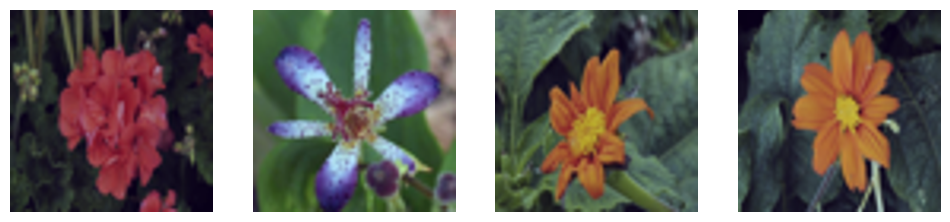

In [14]:
import matplotlib.pyplot as plt

def show_images(images, num_images=4):
    """
    Visualizza un set di immagini.

    Parameters:
        images (torch.Tensor): Le immagini da visualizzare. Devono avere forma (N, C, H, W).
        num_images (int): Il numero di immagini da visualizzare.
    """
    # Seleziona solo il numero di immagini specificato
    images = images[:num_images]

    # Cambia l'ordine dei canali da CHW a HWC per la visualizzazione
    images = images.permute(0, 2, 3, 1)  # (N, H, W, C)

    # Normalizza le immagini nel range [0, 1]
    images = (images - images.min()) / (images.max() - images.min())

    # Crea una figura per visualizzare le immagini
    fig, axs = plt.subplots(1, num_images, figsize=(num_images * 3, 3))

    for i in range(num_images):
        # Mostra l'immagine
        axs[i].imshow(images[i].cpu().detach().numpy())
        axs[i].axis('off')  # Nasconde gli assi per una visualizzazione più pulita

    plt.show()


for images, captions, _ in test_loader:

    print("Min values : {}  | Max Values : {} | type : {}".format(images.min().item(),images.max().item(),images.dtype))
    show_images(images, num_images=4)

    # Rompe il ciclo dopo il primo batch per facilitare la visualizzazione
    break


---------------------------------------

# Creating the GAN model and training it

- Get the image and text embedding

In [15]:
# Per ottenere l'ultimo livello
dim_img_size , dim_text_size = clip_model.get_output_dimensions()
print("Cosa ritorna CLIP due vettori da: :", dim_img_size[1] , dim_text_size[1])

Cosa ritorna CLIP due vettori da: : 512 512


In [16]:
embedding_size = dim_text_size[1]                     # dimensione di output quando codifico il testo con CLIP
p_emb_dim = 128
WGAN_model = WGAN(clip_model,embedding_size,p_emb_dim)

print("Alla classe WGAN viene passato il modello di CLIP gia addestrato da prima sul dataset Flower e due dimensioni (output di clip = {}, proiezione = {})".format(embedding_size,p_emb_dim))


Alla classe WGAN viene passato il modello di CLIP gia addestrato da prima sul dataset Flower e due dimensioni (output di clip = 512, proiezione = 128)


In [ ]:
checkpoints_path = os.path.join(os.getcwd(), "checkpoints")

WGAN_model.fit(
    train_dataloader = train_loader,
    val_dataloader = val_loader,
    num_epochs = 30,
    save_path=checkpoints_path
)

Training on device: cuda


Epoch [1/30] Batch [320/320] Generator loss: -0.387124 | Discriminator loss: 0.741581: 100%|██████████| 320/320 [26:53<00:00,  5.04s/it]


Epoch [1/30] Summary:
	=> Train Generator Loss: -0.387124
	=> Train Discriminator Loss: 0.741581


Validation [96/96] - Generator loss: 0.476986 | Discriminator loss: 0.058181: 100%|██████████| 96/96 [01:47<00:00,  1.12s/it]


	=> Validation Generator Loss: 0.476986
	=> Validation Discriminator Loss: 0.058181


Epoch [2/30] Batch [320/320] Generator loss: -0.402947 | Discriminator loss: 0.744712: 100%|██████████| 320/320 [26:58<00:00,  5.06s/it]


Epoch [2/30] Summary:
	=> Train Generator Loss: -0.402947
	=> Train Discriminator Loss: 0.744712


Validation [96/96] - Generator loss: 0.429442 | Discriminator loss: 0.003088: 100%|██████████| 96/96 [01:46<00:00,  1.11s/it]


	=> Validation Generator Loss: 0.429442
	=> Validation Discriminator Loss: 0.003088


Epoch [3/30] Batch [320/320] Generator loss: -0.421388 | Discriminator loss: 0.754143: 100%|██████████| 320/320 [27:01<00:00,  5.07s/it]


Epoch [3/30] Summary:
	=> Train Generator Loss: -0.421388
	=> Train Discriminator Loss: 0.754143


Validation [96/96] - Generator loss: 0.664986 | Discriminator loss: -0.030989: 100%|██████████| 96/96 [01:46<00:00,  1.11s/it]


	=> Validation Generator Loss: 0.664986
	=> Validation Discriminator Loss: -0.030989


Epoch [4/30] Batch [320/320] Generator loss: -0.411929 | Discriminator loss: 0.664831: 100%|██████████| 320/320 [27:00<00:00,  5.06s/it]


Epoch [4/30] Summary:
	=> Train Generator Loss: -0.411929
	=> Train Discriminator Loss: 0.664831


Validation [96/96] - Generator loss: 0.455998 | Discriminator loss: 0.077592: 100%|██████████| 96/96 [01:48<00:00,  1.13s/it]


	=> Validation Generator Loss: 0.455998
	=> Validation Discriminator Loss: 0.077592


Epoch [5/30] Batch [46/320] Generator loss: -0.385496 | Discriminator loss: 0.649909:  14%|█▍        | 46/320 [03:53<23:13,  5.09s/it]

----------------------------------------------------

# Load trained Model and predict an image based on the caption

In [ ]:
checkpoints_full_path = os.path.join(os.getcwd(), "checkpoints/WGAN_epoch-1.pt") # choose your epoch
aux_model = WGAN(clip_model,embedding_size,p_emb_dim)
WGAN_model = aux_model.load(model_pt_filepath=checkpoints_full_path)

Checkpoint loaded for epoch 1.


generated_images shape torch.Size([64, 3, 64, 64]) 
Min values : -0.9999949932098389  | Max Values : 0.999678373336792 | type : torch.float32


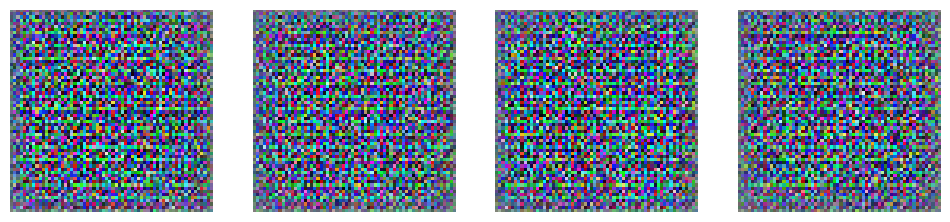

In [ ]:
#for (images, captions, _) in test_loader:
for (images, captions, _) in train_loader:

    generated_images = WGAN_model.predict(captions)
    print("generated_images shape {} ".format(generated_images.shape))  # [256, 3, 224, 224]

    print("Min values : {}  | Max Values : {} | type : {}".format(generated_images.min().item(),generated_images.max().item(),generated_images.dtype))
    show_images(generated_images,num_images=4)

    break

---------------------

# Load model from an epoch and start training from there

In [ ]:
checkpoints_full_path = os.path.join(os.getcwd(), "checkpoints/WGAN_epoch-3.pt")
aux_model = WGAN(clip_model,embedding_size,p_emb_dim)
WGAN_model = aux_model.load(model_pt_filepath=checkpoints_full_path)

Checkpoint loaded for epoch 3.


In [ ]:
checkpoints_path = os.path.join(os.getcwd(), "checkpoints")

WGAN_model.fit(
    train_dataloader = train_loader,
    val_dataloader = val_loader,
    num_epochs = 1,
    save_path=checkpoints_path,
    starting_epoch = 3
)

Checkpoints are present in 'c:\Users\Alex\Documents\GitHub\Deep-Learning-Final-Project\examples\checkpoints', training will start from epoch 3
Training on device: cuda


Epoch [4/4] Batch [13/13] Generator loss: -0.407557 | Discriminator loss: 0.773079: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]


Epoch [7/4] Summary:
	=> Train Generator Loss: -0.407557
	=> Train Discriminator Loss: 0.773079


Validation [13/13] - Generator loss: 0.499635 | Discriminator loss: 0.072753: 100%|██████████| 13/13 [00:01<00:00,  7.39it/s]


	=> Validation Generator Loss: 0.499635
	=> Validation Discriminator Loss: 0.072753
